In [138]:
# Pull phasing data
chromosome = '22'
family_ids, Xs, Ys, row_indices, col_indices = [], [], [], [], []
for filename in os.listdir('data'):
    if filename.endswith('%s.npz' % chromosome):
        data = np.load('data/%s' % filename)
        if 'X' in data and 'Y' in data and 'row_indices' in data and 'col_indices' in data:
            family_ids.append(filename.split('.')[0])
            Xs.append(data['X'])
            Ys.append(data['Y'])
            row_indices.append(data['row_indices'])
            col_indices.append(data['col_indices'])

In [147]:
m = 4*len(family_ids)
n = len(variants)

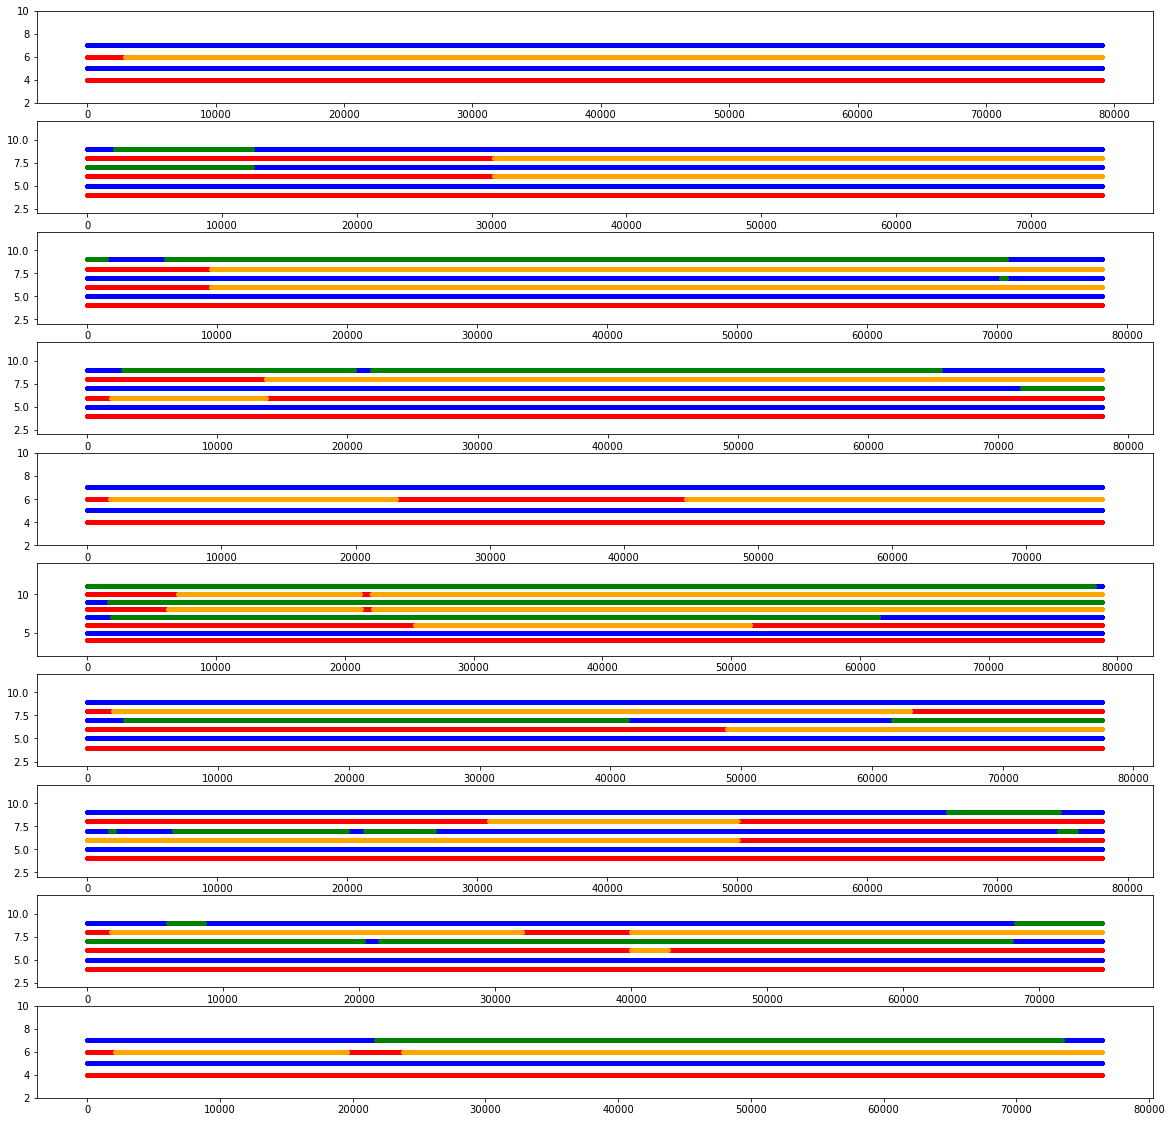

In [150]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))

n = 10
for k, X in enumerate(Xs[:n]):
    if X is not None:
        m, _, _ = X.shape
        plt.subplot(n, 1, k+1)
        for i in range(2, m):
            plt.plot(2*i*X[i, 0, :], linestyle='None', marker='.', color='red')
            plt.plot(2*i*X[i, 1, :], linestyle='None', marker='.', color='orange')
            plt.plot(2*i*X[i, 2, :]+1, linestyle='None', marker='.', color='blue')
            plt.plot(2*i*X[i, 3, :]+1, linestyle='None', marker='.', color='green')

        axes = plt.gca()
        axes.set_ylim([2,(m+1)*2])

plt.show()

In [412]:
chromosome = '9'
maternal_recombinations = []
paternal_recombinations = []
with open('data/recomb%s.txt' % chromosome, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[1] == 'M':
            maternal_recombinations.append(int(pieces[0]))
        else:
            paternal_recombinations.append(int(pieces[0]))
print(len(maternal_recombinations), len(paternal_recombinations))  
    

FileNotFoundError: [Errno 2] No such file or directory: 'data/recomb9.txt'

In [ ]:
# Pull variants
variants = []
with open('data/v34.%s.txt' % chromosome, 'r') as f:
    for line in f:
        variants.append(int(line.strip()))
print(variants[:10], variants[-10:])

In [413]:
# Pull recombination rate from Kong paper
# https://www.ncbi.nlm.nih.gov/pubmed/12053178?dopt=Abstract&holding=npg

rec = [0]*len(variants)
rec_female = [0]*len(variants)
rec_male = [0]*len(variants)
i = 0
with open('recombRate.txt') as f:
    for line in f:
        pieces = line.split('\t')
        chrom = pieces[0]
        start, end = [int(x) for x in pieces[1:3]]
        avg_rec, avg_rec_female, avg_rec_male = [float(x) for x in pieces[4:7]]
        
        if chrom == 'chr' + chromosome:
            while i < len(variants) and variants[i] < start:
                i += 1
            while i < len(variants) and variants[i] < end:
                rec[i], rec_female[i], rec_male[i] = avg_rec, avg_rec_female, avg_rec_male
                i += 1
        

In [414]:
# Pull recombination rate from Bherer paper
# https://github.com/cbherer/Bherer_etal_SexualDimorphismRecombination

bins = list(range(0, len(variants), int(round(len(variants)/100))))
variant_bins = [variants[i] for i in bins]
new_rec, new_rec_female, new_rec_male = [0]*len(bins), [0]*len(bins), [0]*len(bins)

current_bin = 0
with open('data/Refined_genetic_map_b37/sexavg_chr%s.txt' % chromosome, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.split('\t')
        pos = int(pieces[1])
        rr = float(pieces[2])
        
        while variant_bins[current_bin+1] < pos and current_bin+2 < len(bins):
            current_bin += 1
            
        new_rec[current_bin] += rr

current_bin = 0
with open('data/Refined_genetic_map_b37/female_chr%s.txt' % chromosome, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.split('\t')
        pos = int(pieces[1])
        rr = float(pieces[2])
        
        while variant_bins[current_bin+1] < pos and current_bin+2 < len(bins):
            current_bin += 1
            
        new_rec_female[current_bin] += rr
        
current_bin = 0
with open('data/Refined_genetic_map_b37/male_chr%s.txt' % chromosome, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.split('\t')
        pos = int(pieces[1])
        rr = float(pieces[2])
        
        while variant_bins[current_bin+1] < pos and current_bin+2 < len(bins):
            current_bin += 1
            
        new_rec_male[current_bin] += rr
        

In [410]:
markers = []
with open('data/b37.gaps') as f:
    for line in f:
        ch, start, end, marker_type = line.strip().split('\t')
        if ch == chromosome:
            markers.append((int(start), int(end), marker_type))

marker_types = list(set([m[2] for m in markers]))
marker_type_to_index = dict([(v, k) for k, v in enumerate(marker_types)])
mm = np.zeros((len(marker_types), len(variants)))

for j, pos in enumerate(variants):
    for start, end, marker_type in markers:
        if pos >= start-100000 and pos <= end+100000:
            mm[marker_type_to_index[marker_type], j] = 1

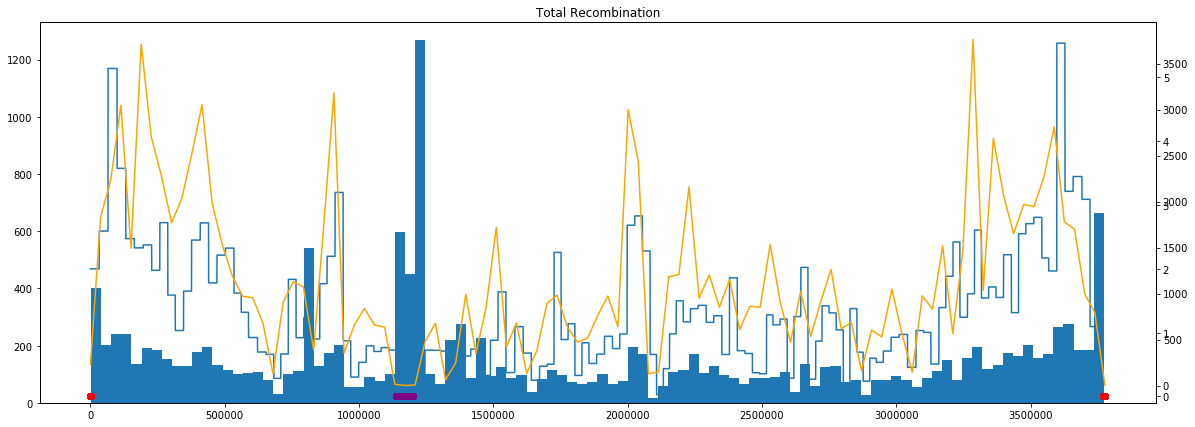

In [411]:
plt.figure(figsize=(20,7))
both_recombinations = maternal_recombinations + paternal_recombinations
both_recombinations.sort()
ax1 = plt.subplot(1, 1, 1)
ax1.hist(both_recombinations, bins=100)
#ax1.set_ylim([0, 350])
ax2 = ax1.twinx()
ax2.plot(rec, label='Kong')
ax2.plot(mm[1, :]-1, linestyle='None', marker='o', label=mt, c='purple')
ax2.plot(mm[0, :]-1, linestyle='None', marker='o', label=mt, c='red')
ax2.set_ylim(bottom=-0.1)
ax3 = ax1.twinx()
ax3.plot(bins, new_rec, label='Bherer', c='orange')
plt.title('Total Recombination')

plt.show()

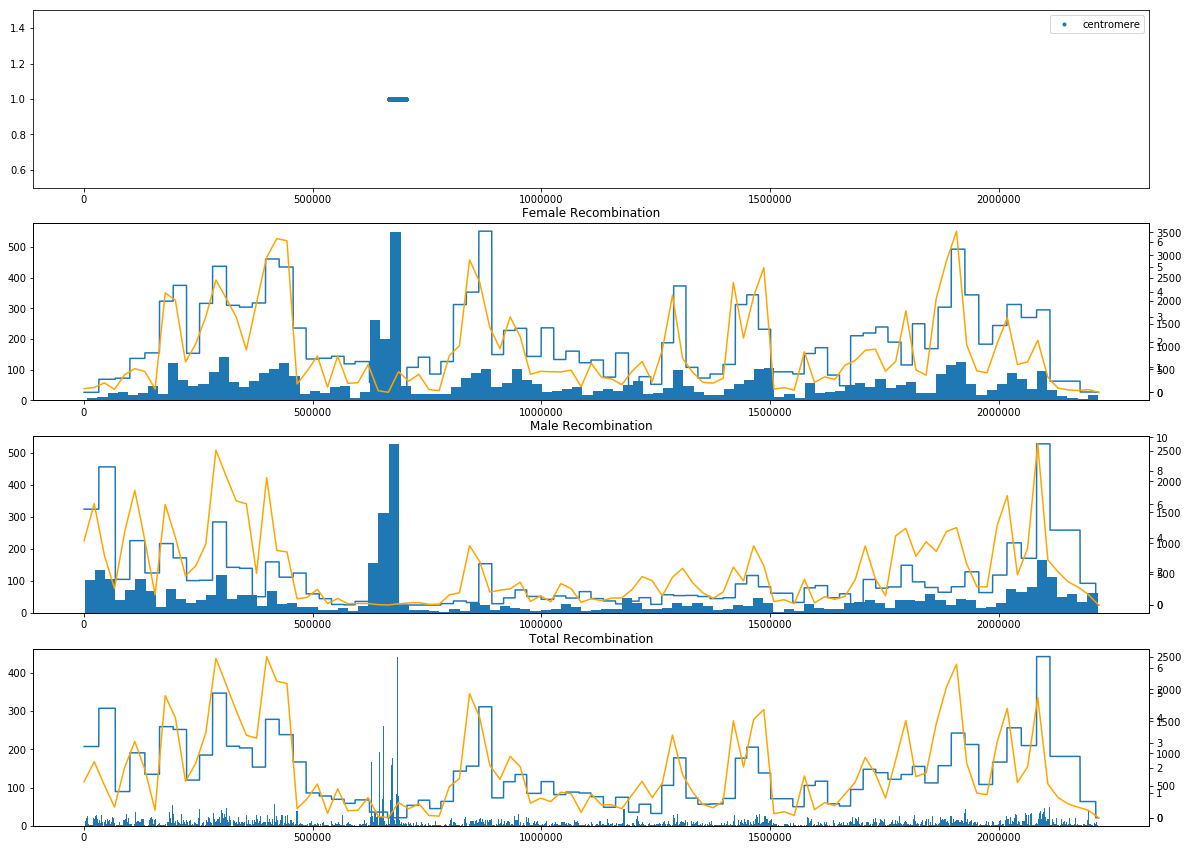

In [356]:
plt.figure(figsize=(20,15))

ax1 = plt.subplot(4, 1, 1)
for i, mt in enumerate(marker_types):
    plt.plot((i+1)*mm[i, :], linestyle='None', marker='.', label=mt)
ax1.set_ylim([0.5, len(marker_types)+0.5])
plt.legend()

ax1 = plt.subplot(4, 1, 2)
ax1.hist(maternal_recombinations, bins=100)
#ax1.set_ylim([0, 100])
ax2 = ax1.twinx()
ax2.plot(rec_female, label='Kong')
ax3 = ax1.twinx()
ax3.plot(bins, new_rec_female, label='Bherer', c='orange')
#ax2.set_ylim([0, 10])
plt.title('Female Recombination')

ax1 = plt.subplot(4, 1, 3)
ax1.hist(paternal_recombinations, bins=100)
#ax1.set_ylim([0, 100])
ax2 = ax1.twinx()
ax2.plot(rec_male, label='Kong')
ax3 = ax1.twinx()
ax3.plot(bins, new_rec_male, label='Bherer', c='orange')
#ax2.set_ylim([0, 10])
plt.title('Male Recombination')

both_recombinations = maternal_recombinations + paternal_recombinations
both_recombinations.sort()
ax1 = plt.subplot(4, 1, 4)
ax1.hist(both_recombinations, bins=1000)
#ax1.set_ylim([0, 350])
ax2 = ax1.twinx()
ax2.plot(rec, label='Kong')
ax3 = ax1.twinx()
ax3.plot(bins, new_rec, label='Bherer', c='orange')
#ax2.set_ylim([0, 10])
plt.title('Total Recombination')

plt.show()

In [255]:
print(variants[:10])

[10023, 10067, 10072, 10085, 10101, 10105, 10129, 10134, 10135, 10166]


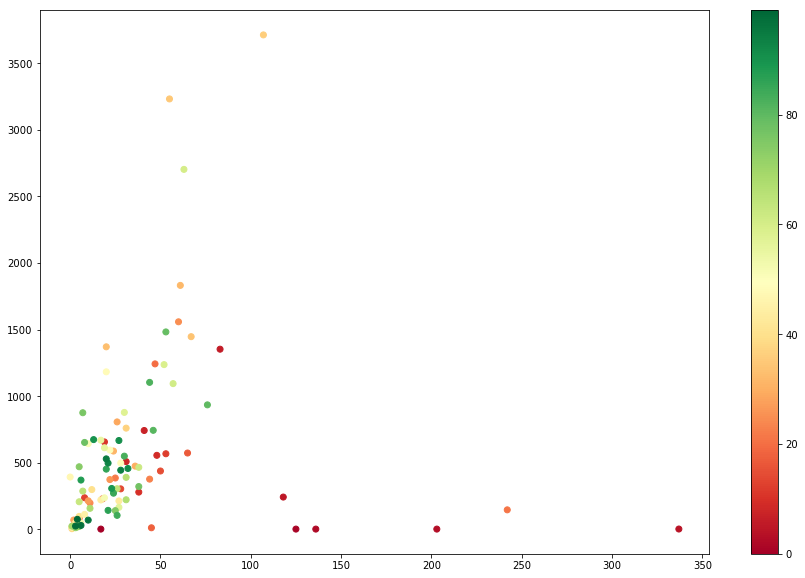

In [196]:
nbin = 100

bins = list(range(0, len(variants), int(round(len(variants)/nbin))))
variant_bins = [variants[i] for i in bins]
recrate = [0]*len(bins)

current_bin = 0
with open('data/Refined_genetic_map_b37/female_chr%s.txt' % chromosome, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.split('\t')
        pos = int(pieces[1])
        rr = float(pieces[2])
        
        while variant_bins[current_bin+1] < pos and current_bin+2 < len(bins):
            current_bin += 1
            
        recrate[current_bin] += rr

plt.figure(figsize=(15,10))
hist, bin_edges = np.histogram(maternal_recombinations, bins=nbin)
ax1 = plt.subplot(1, 1, 1)
plt.scatter(hist, recrate[:nbin], c=range(nbin), cmap='RdYlGn')
plt.colorbar()
#ax1.set_ylim([0, 1000])
#ax1.set_xlim([0, 50])
plt.show()